In [24]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import hstack
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


**Undersampling**

In [25]:
train_df = pd.read_json("../data/processed/IMDB_reviews_train_cleaned.json")
test_df = pd.read_json("../data/processed/IMDB_reviews_test.json")

In [26]:
train_df["is_spoiler"] = train_df["is_spoiler"].astype(int)
test_df["is_spoiler"] = test_df["is_spoiler"].astype(int)

In [27]:
for df in [train_df, test_df]:
    df["review_length"] = df["review_text"].apply(lambda x: len(str(x)))
    df["word_count"] = df["review_text"].apply(lambda x: len(str(x).split()))

prepare TF-IDF features

In [28]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_text = tfidf.fit_transform(train_df["review_text"])
X_test_text = tfidf.transform(test_df["review_text"])

In [29]:
numeric_features = ["polarity", "subjectivity", "review_length", "word_count"]
X_train_numeric = train_df[numeric_features].fillna(0)
X_test_numeric = test_df[numeric_features].fillna(0)

In [30]:
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

In [31]:
X_train = hstack([X_train_text, X_train_numeric])
X_test = hstack([X_test_text, X_test_numeric])

y_train = train_df["is_spoiler"]
y_test = test_df["is_spoiler"]

In [32]:
model = LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.9,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=500
)
random_state = 3244

undersample = RandomUnderSampler(random_state=random_state)
try:
    X_train_u, y_train_u = undersample.fit_resample(X_train, y_train)
except Exception as e:
    print('Undersampler failed on sparse matrix, converting to dense (may use lots of memory):', e)
    X_train_u = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_train_u, y_train_u = undersample.fit_resample(X_train, y_train)

oversample = RandomOverSampler(random_state=random_state)
try:
    X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)
except Exception as e:
    print('Undersampler failed on sparse matrix, converting to dense (may use lots of memory):', e)
    X_train_o = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    X_train_o, y_train_o = oversample.fit_resample(X_train, y_train)

In [33]:
results = []
confusion_matrices = {}
probs = {}

sampling_setups = [
    ("normal",    X_train,    y_train),
    ("undersample", X_train_u, y_train_u),
    ("oversample",  X_train_o, y_train_o),
]

for name, X_tr, y_tr in sampling_setups:    
    model = LGBMClassifier(
        objective="binary",
        boosting_type="gbdt",
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        n_estimators=500,
        random_state=random_state
    )
    model.fit(X_tr, y_tr)

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    f2   = fbeta_score(y_test, y_pred, beta=2)
    rocA = roc_auc_score(y_test, y_pred_prob)
    avgp = average_precision_score(y_test, y_pred_prob)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"F2-score: {f2:.4f}")
    print(f"ROC AUC: {rocA:.4f}")
    print(f"Average Precision (AP): {avgp:.4f}")

    results.append({
        "sampling": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "f2": f2,
        "roc_auc": rocA,
        "avg_precision": avgp
    })
    
    confusion_matrices[name] = confusion_matrix(y_test, y_pred)
    probs[name] = y_pred_prob

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 120868, number of negative: 338256
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_f

C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.7727
Precision: 0.6837
Recall: 0.2459
F1-score: 0.3617
F2-score: 0.2820
ROC AUC: 0.7584
Average Precision (AP): 0.5515
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.7727
Precision: 0.6837
Recall: 0.2459
F1-score: 0.3617
F2-score: 0.2820
ROC AUC: 0.7584
Average Precision (AP): 0.5515
[LightGBM] [Warning] feature_fraction is

C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.6949
Precision: 0.4450
Recall: 0.6691
F1-score: 0.5345
F2-score: 0.6079
ROC AUC: 0.7567
Average Precision (AP): 0.5466
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.6949
Precision: 0.4450
Recall: 0.6691
F1-score: 0.5345
F2-score: 0.6079
ROC AUC: 0.7567
Average Precision (AP): 0.5466
[LightGBM] [Warning] feature_fraction is

C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\alici\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\lightgbm\basic.py:1238: UserWarning: Converting data to scipy sparse matrix.
  _log_warning("Converting data to scipy sparse matrix.")


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Accuracy: 0.7058
Precision: 0.4565
Recall: 0.6483
F1-score: 0.5357
F2-score: 0.5980
ROC AUC: 0.7572
Average Precision (AP): 0.5481
Accuracy: 0.7058
Precision: 0.4565
Recall: 0.6483
F1-score: 0.5357
F2-score: 0.5980
ROC AUC: 0.7572
Average Precision (AP): 0.5481


In [36]:
metrics_df = pd.DataFrame(results).set_index("sampling").T
print(metrics_df)

sampling         normal  undersample  oversample
accuracy       0.772743     0.694856    0.705808
precision      0.683690     0.445022    0.456514
recall         0.245874     0.669118    0.648257
f1             0.361679     0.534533    0.535746
f2             0.281990     0.607895    0.598021
roc_auc        0.758367     0.756728    0.757245
avg_precision  0.551466     0.546616    0.548133


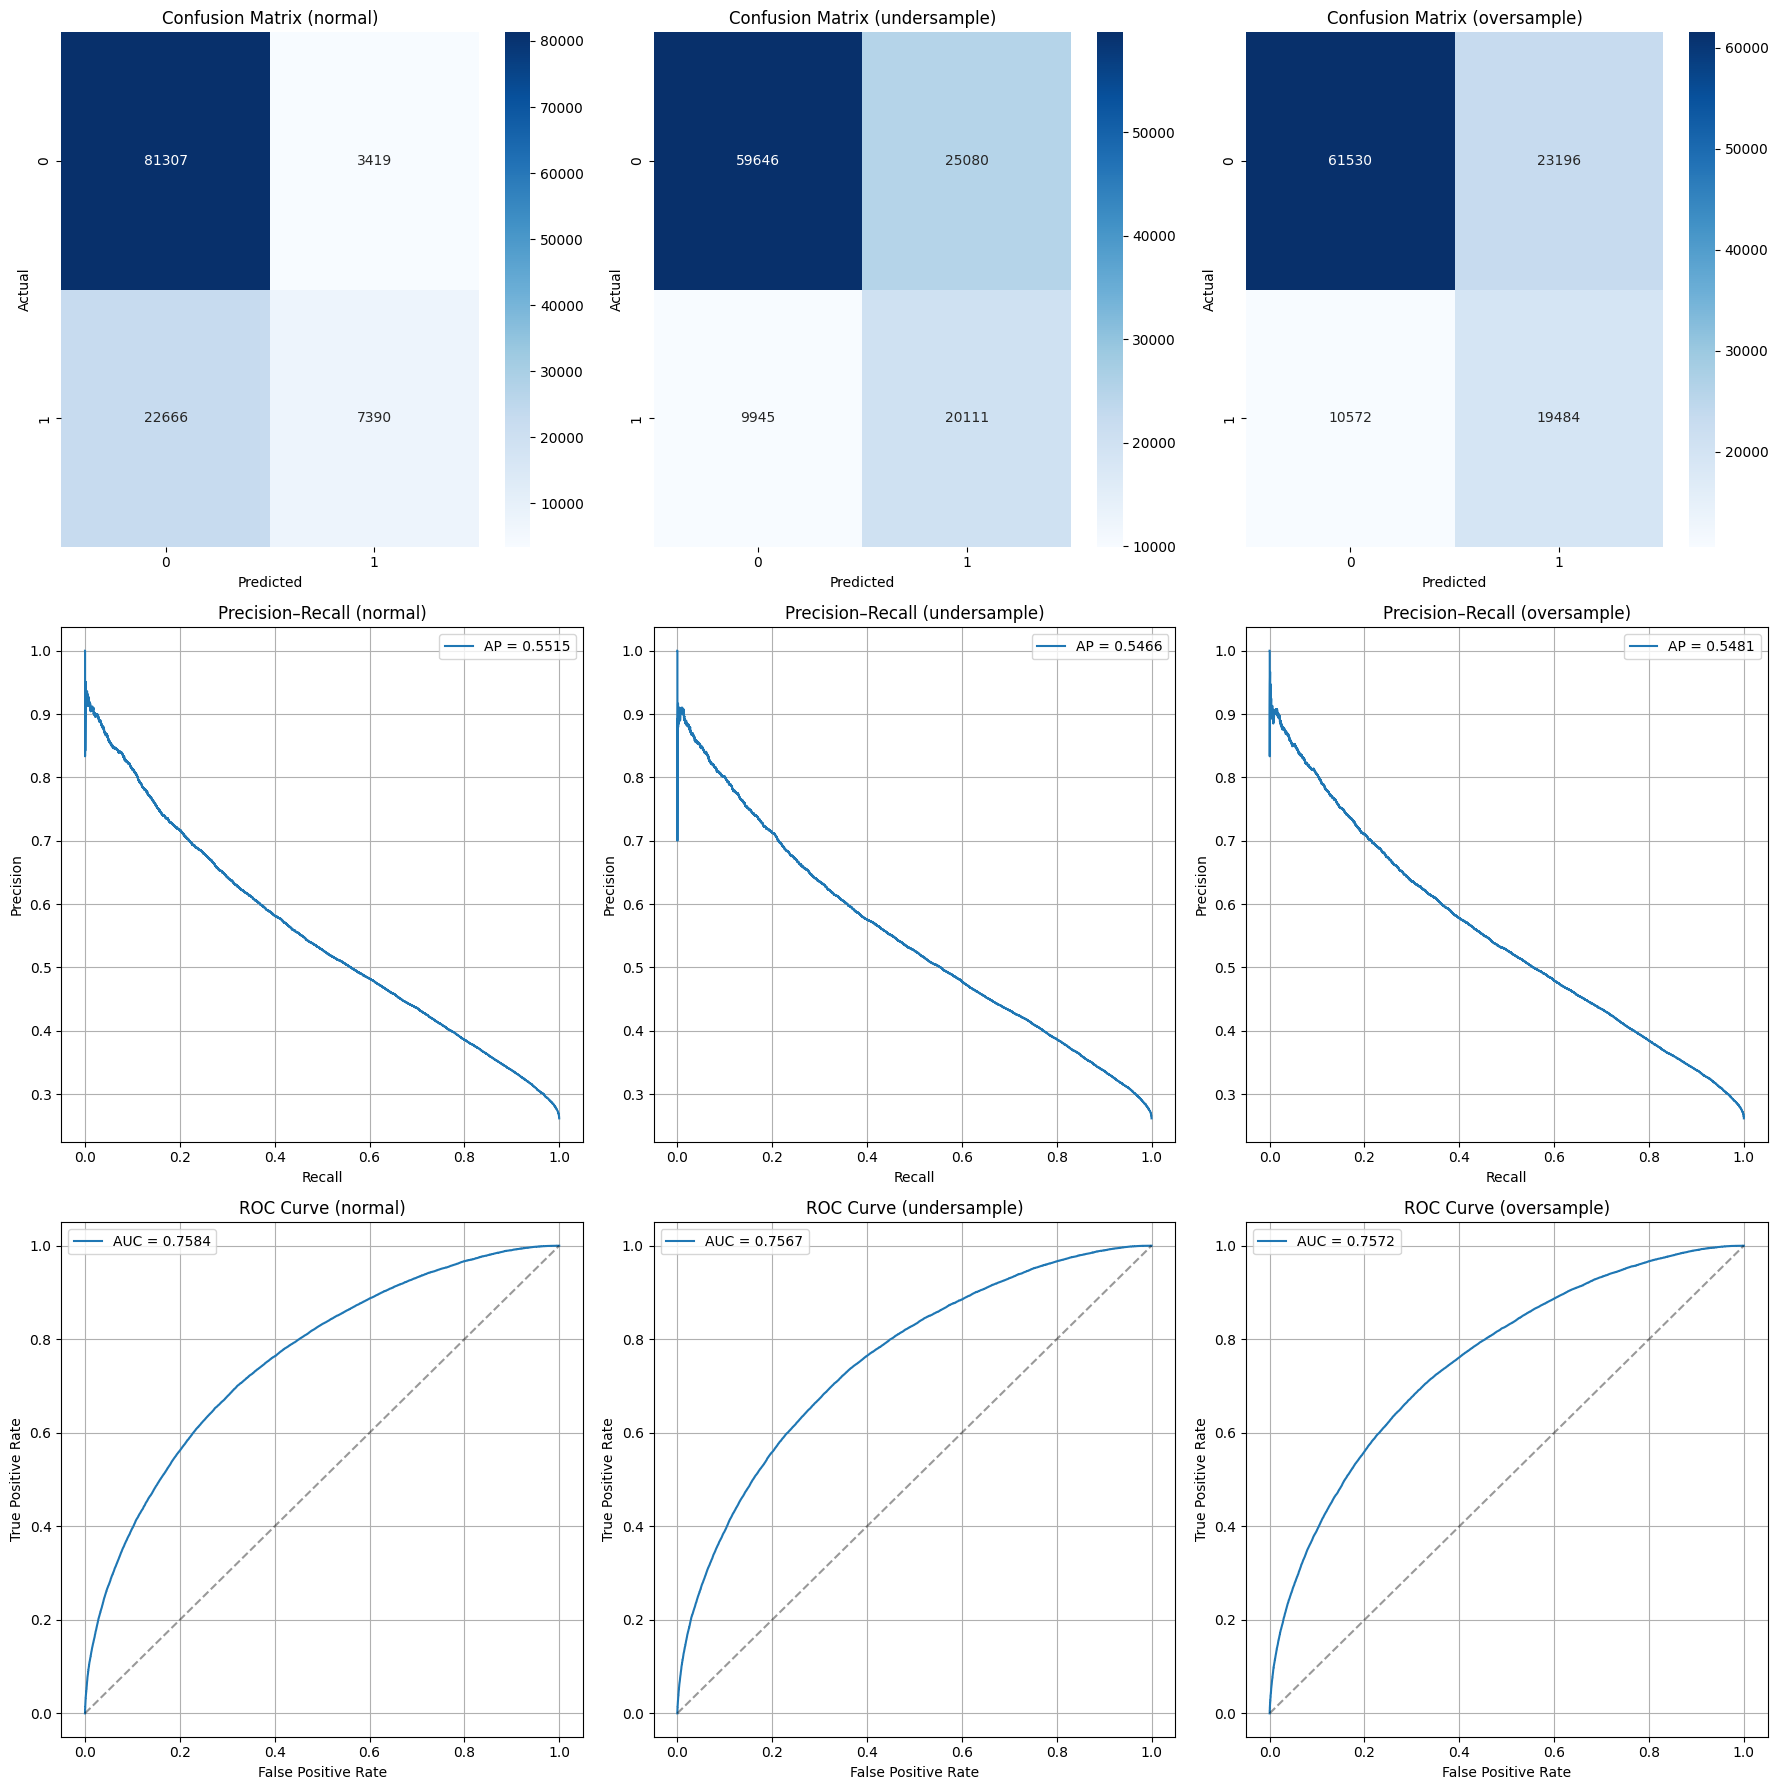

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

order = ["normal", "undersample", "oversample"]

for col, name in enumerate(order):
    cm = confusion_matrices[name]
    ax = axes[0, col]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix ({name})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

for col, name in enumerate(order):
    y_scores = probs[name]
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    
    ax = axes[1, col]
    ax.plot(recall_vals, precision_vals, label=f"AP = {ap:.4f}")
    ax.set_title(f"Precision–Recall ({name})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()
    ax.grid(True)

for col, name in enumerate(order):
    y_scores = probs[name]
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_val = roc_auc_score(y_test, y_scores)

    ax = axes[2, col]
    ax.plot(fpr, tpr, label=f"AUC = {auc_val:.4f}")
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
    ax.set_title(f"ROC Curve ({name})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()
    ax.grid(True)
    
plt.tight_layout()
plt.show()